In [3]:
# Cell 3: Prepare YOLO Dataset (Subset and Labeling)
import os
import random
import shutil
from pathlib import Path

def create_dirs(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

def create_yolo_label(image_path, class_id, output_dir):
    """Create YOLO label file with centered bounding box"""
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(output_dir, f"{image_name}.txt")

    # Create centered bounding box
    x_center = 0.5
    y_center = 0.5
    bbox_width = 1.0
    bbox_height = 1.0

    # Write label file
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

def prepare_yolo_dataset(dataset_path, output_base_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, subset_size=500):
    """
    Prepare dataset for YOLO training by:
    1. Creating a subset of the dataset (e.g., 500 images per class).
    2. Splitting the subset into train/val/test.
    3. Creating labels for the subset.
    """

    # Create output directories
    splits = ['train', 'val', 'test']
    for split in splits:
        create_dirs(os.path.join(output_base_path, 'images', split))
        create_dirs(os.path.join(output_base_path, 'labels', split))

    # Get class directories and create class mapping
    class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_mapping = {class_name: idx for idx, class_name in enumerate(sorted(class_dirs))}

    # Save class mapping
    with open(os.path.join(output_base_path, 'classes.txt'), 'w') as f:
        for class_name in sorted(class_dirs):
            f.write(f"{class_name}\n")

    # Process each class
    for class_name in class_dirs:
        class_path = os.path.join(dataset_path, class_name)
        class_id = class_mapping[class_name]

        # Get all images in class directory
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        # Create a subset of images (e.g., 500 images per class)
        if subset_size > 0:
            images = images[:subset_size]  # Take the first `subset_size` images

        # Calculate split sizes
        n_images = len(images)
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)

        # Split images into train/val/test
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]

        # Process each split
        splits_data = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }

        for split, split_images in splits_data.items():
            for image_name in split_images:
                # Copy image
                src_path = os.path.join(class_path, image_name)
                dst_path = os.path.join(output_base_path, 'images', split, image_name)
                shutil.copy2(src_path, dst_path)

                # Create label
                create_yolo_label(dst_path, class_id,
                                os.path.join(output_base_path, 'labels', split))

if __name__ == "__main__":
    # Define paths
    dataset_path = '/kaggle/input/arabic-food-101/Arabic Food 101 V3/Images'  # Path to your dataset
    output_base_path = '/kaggle/working/yolo_subset_dataset'  # Path to save subset dataset

    # Set random seed for reproducibility
    random.seed(42)

    # Process dataset (create subset and labels)
    prepare_yolo_dataset(dataset_path, output_base_path, subset_size=500)  # 500 images per class

    print("Subset dataset preparation completed!")
    print(f"Output directory structure:")
    print(f"- {output_base_path}/")
    print(f"  ├── images/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  ├── labels/")
    print(f"  │   ├── train/")
    print(f"  │   ├── val/")
    print(f"  │   └── test/")
    print(f"  └── classes.txt")

Subset dataset preparation completed!
Output directory structure:
- /kaggle/working/yolo_subset_dataset/
  ├── images/
  │   ├── train/
  │   ├── val/
  │   └── test/
  ├── labels/
  │   ├── train/
  │   ├── val/
  │   └── test/
  └── classes.txt


In [4]:
import os
import yaml

# تحديد المسار الصحيح
yaml_dir = "/kaggle/working/data/arabic-food-101"
yaml_path = f"{yaml_dir}/data_subset.yaml"

# إنشاء المجلد إذا لم يكن موجودًا
os.makedirs(yaml_dir, exist_ok=True)

# حفظ ملف YAML في المسار الجديد
data_yaml = {"example_key": "example_value"}  # مثال على البيانات داخل الملف
with open(yaml_path, 'w') as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

print(f"تم حفظ ملف YAML بنجاح في: {yaml_path}")


تم حفظ ملف YAML بنجاح في: /kaggle/working/data/arabic-food-101/data_subset.yaml


In [5]:
# Cell 5: Create data.yaml for Subset Dataset
import os
import yaml

def create_data_yaml(dataset_path, output_path, yaml_path):
    """
    Create data.yaml file for YOLOv8 training
    """
    # Get class names from the dataset directory
    class_dirs = [d for d in os.listdir(os.path.join(dataset_path, 'images', 'train'))
                 if os.path.isdir(os.path.join(dataset_path, 'images', 'train', d))]
    class_names = sorted(class_dirs)  # Sort to ensure consistent ordering

    # Create YAML content
    data_yaml = {
        'path': dataset_path,  # dataset root dir
        'train': os.path.join('images', 'train'),  # train images (relative to path)
        'val': os.path.join('images', 'val'),  # val images (relative to path)
        'test': os.path.join('images', 'test'),  # test images (optional)
        'names': {i: name for i, name in enumerate(class_names)},  # class names
        'nc': len(class_names)  # number of classes
    }

    # Save YAML file
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f, sort_keys=False)

    return data_yaml

if __name__ == "__main__":
    # Paths
    dataset_path = '/kaggle/working/yolo_subset_dataset'  # Path to subset dataset
    yaml_path = '/kaggle/working/data/arabic-food-101/data_subset.yaml'  # Where to save the yaml file

    # Create data.yaml
    yaml_content = create_data_yaml(dataset_path, dataset_path, yaml_path)
    print("\nCreated data.yaml with the following content:")
    print("\ndata.yaml content:")
    print(yaml.dump(yaml_content, sort_keys=False))


Created data.yaml with the following content:

data.yaml content:
path: /kaggle/working/yolo_subset_dataset
train: images/train
val: images/val
test: images/test
names: {}
nc: 0



In [6]:
!pip install ultralytics --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.2 MB/s eta 0:00:00a 0:00:01


In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # تحميل نموذج افتراضي


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.4MB/s]


In [ ]:
import os

dataset_path = "/kaggle/working/yolo_subset_dataset/classes.txt"  # تأكد من أن المسار صحيح
classes = sorted(os.listdir(dataset_path))

print(f"عدد الفئات: {len(classes)}")
print(f"أسماء الفئات: {classes}")


In [29]:
from ultralytics import YOLO

# Load the last checkpoint
model = YOLO('/kaggle/input/pretra/best (1).pt')

# Resume training
model.train(
    data='/kaggle/input/theyamlforarabic/data_subset.yaml',
    epochs=30,
    imgsz=512,
    batch=64,
    #resume=True,
    name='food101_yolov8_subset',
    device='0',  # Use GPU (device 0)
    workers=4
)

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/pretra/best (1).pt, data=/kaggle/input/theyamlforarabic/data_subset.yaml, epochs=30, time=None, patience=100, batch=64, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=food101_yolov8_subset5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning /kaggle/working/yolo_subset_dataset/labels/train.cache... 2324 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2324/2324 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo_subset_dataset/labels/val.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]


Plotting labels to runs/detect/food101_yolov8_subset5/labels.jpg... 


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to runs/detect/food101_yolov8_subset5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.46G     0.1487      3.562     0.9394         64        512: 100%|██████████| 37/37 [00:14<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        659        659     0.0923      0.814      0.284      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.36G     0.1328       2.63     0.9151         63        512: 100%|██████████| 37/37 [00:13<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.576      0.545      0.603      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.36G     0.1175      1.861     0.8892         68        512: 100%|██████████| 37/37 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        659        659       0.67      0.634      0.721      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.36G     0.1111      1.376     0.8892         62        512: 100%|██████████| 37/37 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

                   all        659        659      0.714       0.72      0.782      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.36G     0.1014      1.152     0.8832         62        512: 100%|██████████| 37/37 [00:14<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

                   all        659        659      0.764      0.727      0.811      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.36G    0.09646      1.029     0.8836         63        512: 100%|██████████| 37/37 [00:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.01it/s]

                   all        659        659      0.806      0.714      0.837      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.36G    0.09632     0.9747      0.879         65        512: 100%|██████████| 37/37 [00:14<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.858      0.718      0.847      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.36G    0.09767     0.9055     0.8803         59        512: 100%|██████████| 37/37 [00:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        659        659      0.803      0.746       0.84      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.36G    0.08777     0.8756     0.8803         63        512: 100%|██████████| 37/37 [00:14<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        659        659      0.778       0.77      0.847      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.36G    0.08504      0.831      0.879         60        512: 100%|██████████| 37/37 [00:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

                   all        659        659      0.791      0.752      0.853       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.36G    0.08232     0.7975     0.8719         66        512: 100%|██████████| 37/37 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        659        659      0.804      0.767      0.861      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.36G      0.088     0.8018     0.8782         68        512: 100%|██████████| 37/37 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        659        659      0.854      0.747      0.862      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.36G    0.08048      0.751     0.8788         63        512: 100%|██████████| 37/37 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]

                   all        659        659      0.818       0.78      0.867      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.36G    0.07779     0.7432     0.8709         58        512: 100%|██████████| 37/37 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.822      0.787      0.875      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.36G    0.07817     0.7162     0.8719         62        512: 100%|██████████| 37/37 [00:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.821      0.789      0.879      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.36G    0.07763     0.7015      0.877         61        512: 100%|██████████| 37/37 [00:14<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        659        659      0.791      0.806      0.873      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.36G    0.07847     0.6936     0.8694         66        512: 100%|██████████| 37/37 [00:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.848      0.775      0.873      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.36G    0.07682     0.6789      0.874         63        512: 100%|██████████| 37/37 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        659        659      0.831      0.779      0.872      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.36G    0.07726     0.6769     0.8733         65        512: 100%|██████████| 37/37 [00:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        659        659      0.815      0.804       0.88      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.36G    0.07426     0.6634     0.8748         62        512: 100%|██████████| 37/37 [00:14<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

                   all        659        659      0.884      0.745      0.877      0.875


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.36G     0.0677     0.7739      0.857         20        512: 100%|██████████| 37/37 [00:16<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        659        659      0.845      0.769      0.859      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.36G    0.05071     0.5162     0.8474         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        659        659       0.83      0.775      0.867      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.36G     0.0447     0.4566     0.8471         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        659        659      0.827      0.803      0.879      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.36G    0.04243     0.4238     0.8447         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        659        659      0.869      0.775      0.884      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.36G    0.03948      0.395     0.8484         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        659        659      0.825      0.785      0.877      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.36G    0.04105     0.4019     0.8456         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659       0.86       0.79      0.884      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.36G    0.03817     0.3618     0.8404         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]

                   all        659        659      0.848      0.803      0.884      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.36G    0.03532     0.3786     0.8425         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        659        659      0.836      0.798      0.883      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.36G    0.03492     0.3548     0.8421         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        659        659      0.832      0.804      0.882      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.36G    0.03488     0.3556     0.8378         20        512: 100%|██████████| 37/37 [00:14<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.12it/s]

                   all        659        659      0.803      0.833      0.884      0.883



30 epochs completed in 0.153 hours.
Optimizer stripped from runs/detect/food101_yolov8_subset5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/food101_yolov8_subset5/weights/best.pt, 6.2MB

Validating runs/detect/food101_yolov8_subset5/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


                   all        659        659      0.848        0.8      0.884      0.883
             Apple Pie         35         35      0.843      0.769      0.831      0.831
               Falafel         34         34      0.801      0.853      0.919      0.919
            Fava Beans         22         22       0.84          1      0.973      0.973
                Kibbeh         35         35      0.872      0.777      0.821      0.818
                Kunafa         36         36      0.871      0.861      0.895      0.895
               Mahashi         31         31      0.906      0.839      0.878      0.878
              Makmoura         27         27      0.696      0.679       0.77       0.77
                 Mandi         34         34      0.828      0.912      0.922      0.922
                Mansaf         33         33       0.91      0.818      0.941      0.941
               Qatayef         35         35      0.856      0.829      0.925      0.925
        Rice with Mil

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/food101_yolov8_subset5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b92d2435150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [30]:
from ultralytics import YOLO

# Assuming your trained YOLO model is still in memory
model.save('/kaggle/working/food101_yolov8n_model.pt')  # Save to your desired path
print("Model saved successfully!")


Model saved successfully!


In [31]:
# Load the saved YOLO model for testing and inference
loaded_model = YOLO('/kaggle/working/food101_yolov8n_model.pt')  # Replace with your saved model path
print("Model loaded successfully!")


NameError: name 'kaggle' is not defined

In [19]:

results = loaded_model.predict(source="/kaggle/input/kebab1/b751c725a5b8b1879ecfb43998a01402.webp", conf=0.5, imgsz=512, device='cuda')  # Adjust conf if needed


image 1/1 /kaggle/input/kebab1/b751c725a5b8b1879ecfb43998a01402.webp: 256x512 1 Kebab, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 512)


In [32]:
# Test the model on a new dataset or single images
results = model.predict(
    source='/kaggle/working/yolo_subset_dataset/images/test',  # Path to test images
    imgsz=512,  # Image size
    conf=0.5,  # Confidence threshold
    save=True,  # Save predictions
    save_txt=True,  # Save predictions in text format
    device='cuda'  # Use GPU if available
)
print("Testing completed successfully!")



image 1/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (106).png: 480x512 1 Kebab, 1 Muskhan, 9.0ms
image 2/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (116).png: 288x512 1 Kebab, 7.3ms
image 3/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (128).png: 320x512 1 Kebab, 7.4ms
image 4/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (136).png: 288x512 1 Kebab, 6.9ms
image 5/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (140).png: 352x512 1 Muskhan, 7.4ms
image 6/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (149).png: 352x512 1 Kebab, 6.6ms
image 7/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (168).png: 480x512 1 Kebab, 6.7ms
image 8/350 /kaggle/working/yolo_subset_dataset/images/test/Download-Locationكباب (169).png: 352x512 1 Kebab, 6.9ms
image 9/350 /kaggle/working/yolo_subset_dataset/images/tes

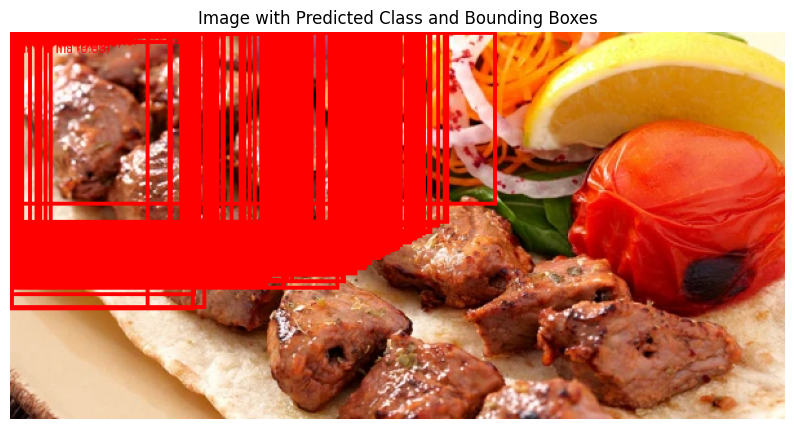

In [33]:
from PIL import Image, ImageDraw  # Import Pillow
import matplotlib.pyplot as plt  # Import Matplotlib

# Load the original image
original_img = Image.open("/kaggle/input/kebab1/b751c725a5b8b1879ecfb43998a01402.webp")
original_img_draw = original_img.copy()
draw = ImageDraw.Draw(original_img_draw)

# Retrieve predictions from the model
for result in results:
    for box in result.boxes:
        # Extract bounding box, confidence, and class
        x1, y1, x2, y2 = box.xyxy[0]  # Bounding box coordinates
        conf = box.conf[0].item()  # Confidence score
        cls = box.cls[0].item()  # Predicted class index
        label = result.names[int(cls)]  # Class label from the model

        # Draw bounding box and label
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1), f"{label} ({conf:.2f})", fill="red")

# Plot the image with predictions
plt.figure(figsize=(10, 10))
plt.imshow(original_img_draw)
plt.axis("off")
plt.title("Image with Predicted Class and Bounding Boxes")
plt.show()


In [34]:
from ultralytics import YOLO

# Load the trained model
model = YOLO('/kaggle/working/food101_yolov8n_model.pt')  # Adjust path if needed

# Run inference on an image
results = model('/kaggle/input/kebab1/b751c725a5b8b1879ecfb43998a01402.webp', save=True, show=True)  # Replace with your test image

# Extract detected food names
detected_foods = []

for r in results:
    for box in r.boxes.data:
        class_id = int(box[5])  # Class ID from YOLO output
        food_name = model.names[class_id]  # Get food name from class ID
        detected_foods.append(food_name)

# Store the first detected food in a variable (if any food is detected)
if detected_foods:
    food_item = detected_foods[0]  # Get the first detected food
    print("Detected Food:", food_item)
else:
    print("No food detected.")

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /kaggle/input/kebab1/b751c725a5b8b1879ecfb43998a01402.webp: 256x512 1 Kebab, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 512)
Results saved to runs/detect/predict4
Detected Food: Kebab


In [35]:
import requests

# Nutritionix API credentials
APP_ID = "beeae400"
APP_KEY = "a119ce8afb23f7a1f518ce7175161e9d"

# Nutritionix API endpoint
NUTRITIONIX_URL = "https://trackapi.nutritionix.com/v2/natural/nutrients"

# Function to get calories from Nutritionix
def get_calories(food_item, portion_size_grams):
    headers = {
        "x-app-id": APP_ID,
        "x-app-key": APP_KEY,
        "Content-Type": "application/json",
    }
    data = {
        "query": f"{portion_size_grams}g of {food_item}",
    }
    response = requests.post(NUTRITIONIX_URL, headers=headers, json=data)
    
    if response.status_code == 200:
        food_data = response.json()["foods"][0]
        calories = food_data["nf_calories"]
        print(f"{portion_size_grams}g of {food_item}: {calories:.2f} calories")
        return calories
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Example: Detected food items and portion sizes (manually provided by the user)
detected_foods = [
    {"category": "pizza", "portion_size_grams": 200},  # 200g of pizza
    {"category": "rice", "portion_size_grams": 150},   # 150g of rice
]

# Calculate total calories
total_calories = 0
for food in detected_foods:
    category = food["category"]
    portion_size = food["portion_size_grams"]
    calories = get_calories(category, portion_size)
    if calories:
        total_calories += calories
        #print(f"{portion_size}g of {category}: {calories:.2f} calories")
    else:
        print(f"Could not retrieve calories for {category}")

print(f"Total calories: {total_calories:.2f}")

200g of pizza: 532.00 calories
150g of rice: 195.00 calories
Total calories: 727.00


In [36]:
cal=get_calories(food_item,100)

100g of Kebab: 185.34 calories
